## A Network Approach to Genetic and Expression based Phenotype Prediction on Mouse

Gianni Giusto, Yann Mentha, Raphaël Reis, Lucas Zweili

_Code available on the [GitHub](https://github.com/raphaelreis/Network_tour_of_mice_genetics) repository._

_____


In [1]:
#General
import glob
import os
import os.path

import numpy as np
import pandas as pd
from utils import *
import seaborn as sns
from os import listdir 
import matplotlib.pyplot as plt 
from ipywidgets import IntSlider, interact
from tabulate import tabulate
from IPython.core.debugger import set_trace
from pycm import *
import re
import pickle

#Graph Network
import networkx as nx
from networkx.algorithms import node_classification
from pygsp import graphs, learning, filters, plotting
import itertools


#Scipy
from scipy import stats
from scipy.stats import norm
from scipy.stats import zscore
from scipy.spatial.distance import pdist, squareform

#Sklearn
from sklearn.utils import shuffle
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error,accuracy_score,f1_score,matthews_corrcoef
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif, chi2, RFE
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.model_selection import cross_val_predict, cross_val_scoret,train_test_split


#Keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

#Torch
import torch as th
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

%matplotlib inline
%load_ext autoreload
%autoreload 2

## 1. Summary

|          | Description                                                  |         Amount |
| -------- | ------------------------------------------------------------ | -------------: |
| nodes    | mice                                                         |      100 - 200 |
| edges    | similar genes, protein expressions, or phenotypes            | O(10) per node |
| features | genes, protein expressions in tissues, or phenotypes         |          1000s |
| labels   | depends: a particular gene, phenotype, or protein expression |            N/A |

## 2. Acquisition

In [3]:
data_folder = './../data/BXD data-3/'

##### *Genotype*

In [4]:
df_genotype = pd.read_csv(data_folder + 'genotype_BXD.txt', delimiter ="\t", index_col='SNP').transpose()
df_genotype.index.name = 'BDX_strain'
df_genotype.head()

SNP,rs31443144,rs6269442,rs32285189,rs258367496,rs32430919,rs36251697,rs30658298,rs51852623,rs31879829,rs36742481,...,rs47382998,rs13484107,rs3693969,DXMit223,rs31638776,rs31639754,rs46326766,rs31412493,rs31417520,UT-M-9461
BDX_strain,,,,,,,,,,,,,,,,,,,,,
B6D2F1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,-1
D2B6F1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,-1,-1,-1,1
C57BL.6J,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
DBA.2J,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
BXD1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,1,1,-1


##### *Phenotype*

In [5]:
df_phenotype = pd.read_csv(data_folder + "Phenotype.txt", delimiter="\t", index_col='PhenoID').transpose() 
df_phenotype.index.name = 'BXD_strain'
print(df_phenotype.shape)

(97, 5092)


## 3. Exploration 

#### 3.1 Build the network

In [6]:
# Adjacency for progeny strains only (remove P generations)
strains = df_genotype.index.to_list()[4:]
genotype_adjacency = hl.get_adjacency(df_genotype.loc[strains].to_numpy(), 'cosine', sigma=0.53, epsilon=0.27)

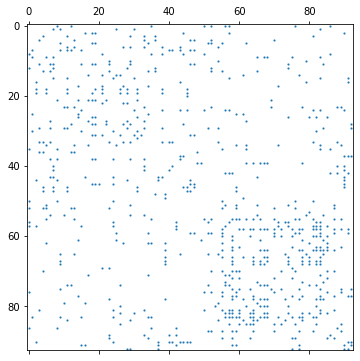

In [7]:
plt.subplots(figsize=(6,6))
plt.spy(genotype_adjacency, markersize=1)

C:\Users\Gianni\Anaconda3\envs\ntds_2019\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


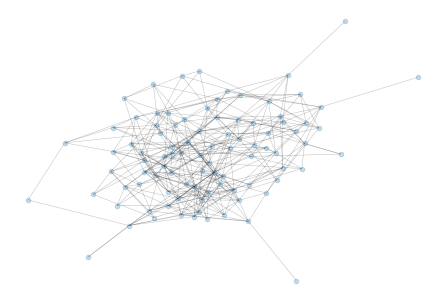

In [8]:
genotype_graph = nx.from_numpy_array(genotype_adjacency)
nx.draw(genotype_graph,node_size=20,width=0.5, alpha=0.25)

In [9]:
hl.graph_basic_stats(genotype_graph)

╒═════════════════════════════════════════════════╤════════╕
│ Number of nodes                                 │  93    │
├─────────────────────────────────────────────────┼────────┤
│ Number of edges                                 │ 373    │
├─────────────────────────────────────────────────┼────────┤
│ Graph density                                   │   8.72 │
├─────────────────────────────────────────────────┼────────┤
│ Average degree                                  │   8.02 │
├─────────────────────────────────────────────────┼────────┤
│ Number of connected components                  │   1    │
├─────────────────────────────────────────────────┼────────┤
│ Average clustering coefficient                  │   0.26 │
├─────────────────────────────────────────────────┼────────┤
│ Diameter of the network (longest shortest path) │   6    │
╘═════════════════════════════════════════════════╧════════╛


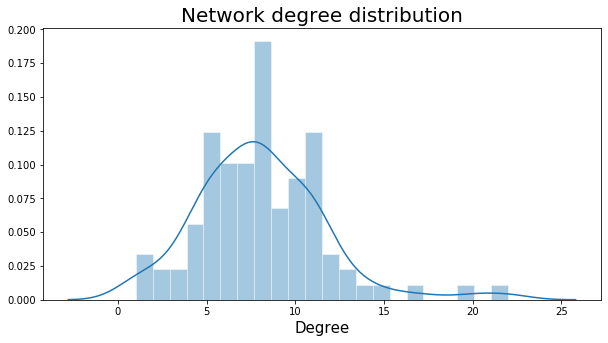

In [10]:
# Degree distribution
adj = genotype_adjacency.copy()
adj[genotype_adjacency > 0] = 1

degrees = adj.sum(1)
deg_hist_normalization = np.ones(degrees.shape[0]) / degrees.shape[0]

fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xlabel('Degree', fontsize=15)
ax.set_title('Network degree distribution', fontsize=20)
sns.distplot(degrees, ax=ax, bins=22, kde=True, hist_kws=dict(edgecolor="w", linewidth=1, weights=deg_hist_normalization))

In [11]:
fig.savefig('degree_distribution.png')

#### 3.2 Network simulation

##### *Erdos-Rényi network*

In [12]:
n = len(genotype_graph.nodes())
m = np.round(genotype_graph.size() / 2)

# Graph parameter
p = 2*m / (n * (n-1))
G_er = nx.erdos_renyi_graph(n, p)

print('My Erdos-Rényi network that simulates the citation graph has {} edges.'.format(G_er.size()))

My Erdos-Rényi network that simulates the citation graph has 182 edges.


##### *Barabási-Albert network*

In [13]:
q=2
assert (q*(n-q) - m) < 50

G_ba = nx.barabasi_albert_graph(n, q)

print('My Barabási-Albert network that simulates the citation graph has {} edges.'.format(G_ba.size()))

My Barabási-Albert network that simulates the citation graph has 182 edges.


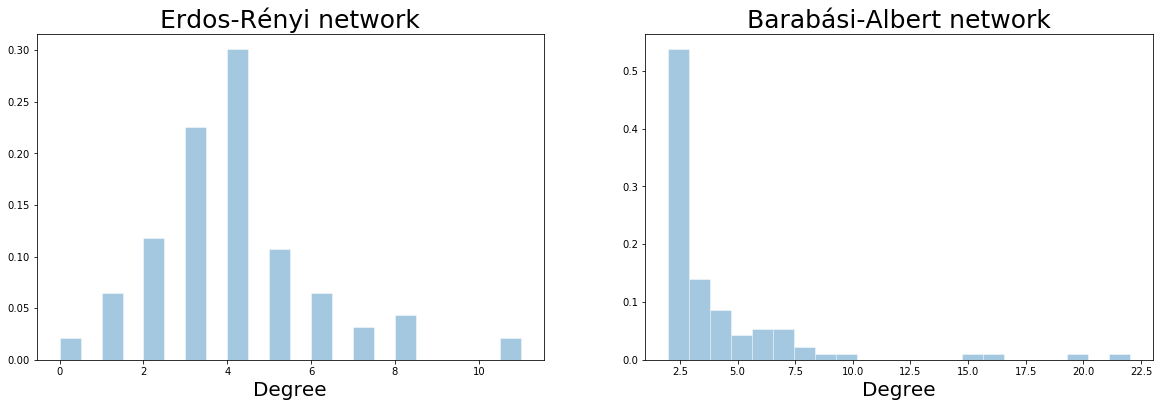

In [14]:
er_degrees = [degree for node, degree in G_er.degree()]
ba_degrees = [degree for node, degree in G_ba.degree()]

fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax[0].set_xlabel('Degree', fontsize=20)
ax[0].set_title('Erdos-Rényi network', fontsize=25)
sns.distplot(er_degrees, ax=ax[0], bins=22, kde=False, hist_kws=dict(edgecolor="w", linewidth=1, weights=deg_hist_normalization))

ax[1].set_xlabel('Degree', fontsize=20)
ax[1].set_title('Barabási-Albert network', fontsize=25)
sns.distplot(ba_degrees, ax=ax[1], bins=22, kde=False, hist_kws=dict(edgecolor="w", linewidth=1, weights=deg_hist_normalization))

In [15]:
fig.savefig('generated_models.png')

#### 3.3 Grid search approach

<div class="alert alert-block alert-info">
    
* genotype_df: contains the genotype of each strain for each allele
* phenotype_df : contains the phenotypes of each strain, lots of Nan

NB: on this branch of the project, we don't use the expression of the genes, and try instead to predict straight the phenotype from the genotype: therefore, we don't import any file from expression data.
</div>

In [89]:
genotype_df = pd.read_csv("data/genotype_BXD.txt", sep='\t', index_col='SNP')
# Remove F0 and F1 generation (parental)
genotype_df.drop(['B6D2F1', 'D2B6F1', 'C57BL.6J', 'DBA.2J'], axis=1, inplace=True)
genotype_df = genotype_df.transpose()
genotype_df.index.name = 'BXD_strain'
phenotype_df = pd.read_csv("data/Phenotype.txt", sep='\t', index_col='PhenoID')
# Remove F0 and F1 generation (parental)
phenotype_df.drop(['B6D2F1', 'D2B6F1', 'C57BL.6J', 'DBA.2J'], axis=1, inplace=True)
nan_count = phenotype_df.isna().sum().sum()
entries_count = phenotype_df.shape[0] * phenotype_df.shape[1]

<div class="alert alert-block alert-info">
The phenotype id aligner gives us insight in the characteristics of the different genes.
</div>

In [90]:
# Phenotype id aligne is an in-depth description of each phenotype
phenotype_id_aligner = pd.read_csv('data/phenotypes_id_aligner.txt', sep='\t', encoding='latin1')
phenotype_id_aligner.rename({'Quantitive.trait': 'quantitative_trait'}, axis=1, inplace=True)
quant_pheno_best = phenotype_id_aligner[(phenotype_id_aligner.Strains > 70) & (phenotype_id_aligner.quantitative_trait == 'No')]
quant_pheno_best = quant_pheno_best.sort_values(by='Strains', ascending=False)
phenotype_id_aligner.set_index('PhenoID',inplace=True)

In [91]:
phenotype_id_aligner.loc['X62']

PhenoID.1                                                            62
RecordID                                                          11280
Phenotype             Skin, pigmentation: Hair coat color, ordinal s...
Shown_pheno           Hair coat color, ordinal scale version 2 where...
Category                                                     Morphology
Category_ID                                                        2628
color                                                                 9
Phenotype_post        Skin, pigmentation: Hair coat color, ordinal s...
Phenotype_pre         Skin, pigmentation: Hair coat color, ordinal s...
Authors                                 Lu Lu, Jing Gu, Robert Williams
Senior.Author                                                  Williams
Abbreviation                                                        NaN
quantitative_trait                                                   No
Tissues                                                         

<div class="alert alert-block alert-info">
We construct a weighted similarity graph and keep only the edges whose exponential value are above a given threshold epsilon : we can construct our graph based on 2 types of information: either genetic or expressive (protein expression). 
</div>

In [92]:
def epsilon_similarity_graph(X: np.ndarray, metric='euclidean', sigma=1, epsilon=0):
    """ X (n x d): coordinates of the n data points in R^d.
        sigma (float): width of the kernel
        epsilon (float): threshold
        Return:
        adjacency (n x n ndarray): adjacency matrix of the graph.
    """
    if np.isnan(X).any():
        Dists = squareform(np.array([pdist(X[s][:, ~np.isnan(X[s]).any(axis=0)], metric) for s in map(list, itertools.combinations(range(X.shape[0]), 2))]).ravel())
        Dists[Dists == 0] = 1E8
        Dists = np.nan_to_num(Dists,nan = 1E8)
    else:
        Dists = squareform(pdist(X,metric = metric))

    Dists = np.exp(-Dists**2/(2 * sigma**2))
    Dists[Dists <= epsilon] = 0
    np.fill_diagonal(Dists,0)
    return Dists

In [93]:
def plot_distrib(adjacency):
    """ Plot the density of kerneled distances
    adjacency : adjacency matrix
    """
    non_zero = adjacency[np.nonzero(adjacency)]
    print("{:0.2f} % of the original data is kept".format(non_zero.size / adjacency.size * 100))
    plt.plot(np.sort(non_zero)[::-1])

 Genotype similarity graph

<div class="alert alert-block alert-info">
We use the gene presence/absence according to different genes couples with a metric such as the cosine or jaccard distance in order to build the graph.
</div>

59.22 % of the original data is kept


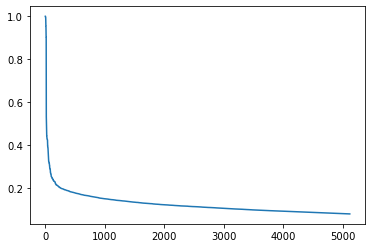

In [94]:
k = epsilon_similarity_graph(genotype_df.values,sigma = 0.45,epsilon = 0.08,metric = 'cosine')
plot_distrib(k)

40.31 % of the original data is kept


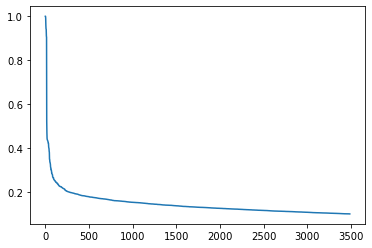

In [95]:
k = epsilon_similarity_graph(genotype_df.values,sigma = 0.23,epsilon = 0.1,metric = 'hamming')
plot_distrib(k)

30.64 % of the original data is kept


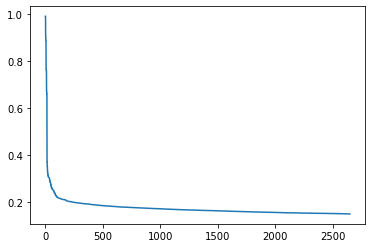

In [96]:
k = epsilon_similarity_graph(genotype_df.values,sigma = 60,epsilon = 0.15,metric = 'euclidean')
plot_distrib(k)

<div class="alert alert-block alert-info">
In order to deal with missing values, we compute the distance according to the given criteria (minkowsky,l2 etc) only on the common features. If 2 samples don't share any feature, then they are considered disconnected.
</div>

In [97]:
with open('results/pickle/concat_expression.pkl','rb') as f:
    expr_df = pickle.load(f)
expr_df['nancount'] = expr_df.isnull().sum(axis = 1)
expr_df = expr_df.sort_values(by = 'nancount').head(100000).drop(columns = ['nancount'])
#remove the mouses which don't have information in this top
expr_df = expr_df.T[~expr_df.isna().all()]

49.82 % of the original data is kept


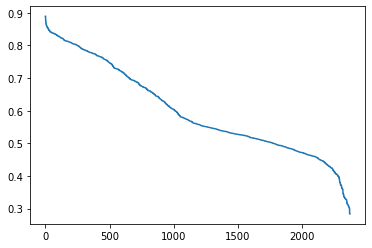

In [98]:
m = epsilon_similarity_graph(expr_df.values,sigma = 70,epsilon = 0.2,metric = 'minkowski')
plot_distrib(m)

49.57 % of the original data is kept


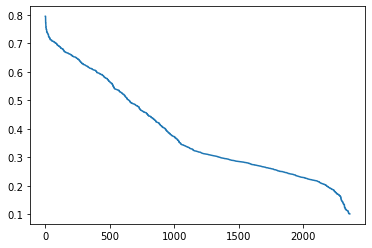

In [99]:
#Same is done with L1 distance
m = epsilon_similarity_graph(expr_df.values,sigma = 50,epsilon = 0.1,metric = 'minkowski')
plot_distrib(m)

<div class="alert alert-block alert-info">
At that point, all we need is a pygsp graph describing the different strains created from an adjacency matrix: the way it is linked is therefore critical for the success of the algorithm.
</div>

In [100]:
def get_min_max(params_scores):
    """
    params_scores: list of list with each row having the following information
    f1,acc,met,sig,eps,tau
    """
    #we sort according to the first metric written in the array
    sorto = lambda x: x[0]
    mino = min(params_scores,key = sorto)[0]
    maxo = max(params_scores,key = sorto)[0]
    return mino,maxo

In [101]:
def grid_search_graphs(bio_df,CV_meth,metrics,sigmas,epsilons,taus,phenotypes,file_name):
    """
    grid_search_graphs performs a grid search over the parameters:
    metric,sigmas,epsilons and taus. A CV is done for each combination of parameters, and gets stored in
    the list params_scores.
    
    bio_df :         genotype_df or expr_df
    CV_meth:         a method performing cross validation (on discrete or continuous variable)
    metrics:         list of metrics usable in a pdist matrix
    sigmas,epsilons: parameter for the adjacency matrix we do the grid search on
    phenotypes:      list of phenotypes we want to be able to predict
    """
    params_scores = {phen:[] for phen in phenotypes}
    for i,met in enumerate(metrics):
        for j,sig in enumerate(sigmas[met]):
            for k,eps in enumerate(epsilons[met]):
                tot_comb = len(metrics) * len(sigmas[met]) * len(epsilons[met]) * len(taus)
                for l,tau in enumerate(taus):
                    ind = l + len(taus) * (k + len(epsilons[met]) * (j + len(sigmas[met]) * (i)))
                    print("%i / %i combinations" % (ind+1,tot_comb))
                    try:
                        weighted_adjacency = epsilon_similarity_graph(bio_df.values, metric=met, sigma=sig, epsilon=eps)
                        for ind_phen,phen in enumerate(phenotypes):
                            #print("%i/%i phenotype" % (ind_phen,len(phenotypes)))
                            try:
                                pygsp_weighted_graph = graphs.Graph(weighted_adjacency,lap_type='normalized')
                                #met1 = MCC/R2 // met2 = acc/MSE
                                met1,met2 = CV_meth(pygsp_weighted_graph,phenotype_df.loc[phen],bio_df,tau)
                                params_scores[phen].append([met1,met2,met,sig,eps,tau])
                                #we save it in case it crashes
                                with open('results/' + file_name + '.pickle','wb') as f:
                                    pickle.dump(params_scores,f)
                                mino,maxo = get_min_max(params_scores[phen])
                                #print('Biggest result for phenotype {a} : {b:.2f} \nSmallest result for phenotype {c} : {d:.2f}'.format(a =phen,b=maxo,c=phen,d=mino))
                            #we don't want the gridsearch to stop in case of an error
                            except Exception as e:
                                print('ERROR')
                                print(e.__doc__,str(e))
                                continue
                    except nx.NetworkXError:
                        print('non connected graph with %.2f sigma and %.2f epsilon' % (sig,eps))
                        continue
    
    return params_scores
    

In [664]:
def CV_discrete(pygsp_weighted_graph,gene_serie,bio_df,tau,NUM_REPET = 50,plot = False):
    """
    CV_discrets performs a cross_validation by taking a random subset repr 20% (test set)of the graph defined above, training a tikhonov classifier
    on the training set( 80%) and return the MCC and the accuracy for the  given parameters.
    pygsp_weighted_graph: the graph built thanks to the adjacency matrix
    bio_df: either genotype_df or expr_df
    tau: regularization parameter for tikhonov
    """
    y_true = gene_serie[bio_df.index]
    nan_present = y_true.isnull().any()
    
    #we keep trace of the mapping
    mapping = dict(zip(y_true.astype('category').cat.codes + 1, y_true))
    
    if nan_present:
        nan_indxes = np.where(np.isnan(y_true))[0]
        y_true = y_true.astype('category').cat.codes
        y_true = y_true + 1
        assert(y_true[nan_indxes][0] == 0)
    else:
        y_true = y_true.astype('category').cat.codes
        y_true = y_true + 1
    
    met,acc = 0,0
    for i in range(NUM_REPET):
        rs = np.random.RandomState()
        train_mask = rs.uniform(0,1,pygsp_weighted_graph.N) > 0.2
        #we make sure that the nan always end up in the train
        if nan_present:
            train_mask[nan_indxes] = True
        labels_true = y_true[~train_mask]
        y_sparse = y_true.copy()
        y_sparse[~train_mask] = np.nan

        recovery = learning.classification_tikhonov(pygsp_weighted_graph,y_sparse,train_mask,tau=tau)
        
        #we get rid of the 0 value: we don't accept no label
        if nan_present:
            recovery[:,0] = -1
        prediction = np.argmax(recovery, axis=1)
        
        labels_pred = prediction[~train_mask]
        met += matthews_corrcoef(labels_true,labels_pred)
        acc += accuracy_score(labels_true,labels_pred)
    #set_trace()
    met_final = met/NUM_REPET
    acc_final = acc/NUM_REPET
    if plot:
        print('Used mapping: \t',mapping)
        #useful to chose metrics
        cm = ConfusionMatrix(actual_vector=labels_true.values, predict_vector=labels_pred)
        print('MCC:%.2f \nAccuracy:%.2f'% (met_final,acc_final))
        fig, ax = plt.subplots(1, 3, sharey=True, figsize=(20, 6))
        limits = [min(y_true.unique().min(),0),y_true.unique().max()+ 1]

        #ground truth
        pygsp_weighted_graph.plot_signal(y_true, ax=ax[0], title='Ground truth',limits = limits)
        #measurements
        pygsp_weighted_graph.plot_signal(y_sparse, ax=ax[1], title='Measurements',limits = limits)
        #recover
        prediction = [limits[1] + 1 if i == j and not k else i for i,j,k in zip(prediction,y_true,train_mask)]
        pygsp_weighted_graph.plot_signal(prediction, ax=ax[2], title='Recovered class',limits = limits)
        #plt.savefig('./results/7324_color.png')
        
    return met_final,acc_final

In [103]:
def CV_continuous(pygsp_weighted_graph,gene_serie,bio_df,tau,NUM_REPET = 50,metric_meth = mean_squared_error,plot = False):
    """
    equivalent
    """
    ycont_true = gene_serie[bio_df.index]
    ycont_true.fillna(ycont_true.mean(),inplace = True)
    #mae or mse
    mxe = 0
    r2 = 0
    for i in range(NUM_REPET):
        mask = np.random.RandomState().uniform(0,1,pygsp_weighted_graph.N) > 0.2
        vals_true = ycont_true[~mask]
        ycont_sparse = ycont_true.copy()
        ycont_sparse[~mask] = np.nan

        recovery = learning.regression_tikhonov(pygsp_weighted_graph,ycont_sparse,mask,tau=tau)
        if any(np.isnan(recovery)):
            return np.nan
        vals_pred = recovery[~mask]
        mxe += metric_meth(vals_true,vals_pred)
        r2 += r2_score(vals_true,vals_pred)

    mxe_avg = mxe / NUM_REPET
    r2_avg = r2 / NUM_REPET
    if plot:
        print(str(metric_meth)+ "%.2f \nr2: %.2f" % (mxe_avg,r2_avg))
        fig, ax = plt.subplots(1, 3, sharey=True, figsize=(20, 6))
        limits = [ycont_true.min(),ycont_true.max()]

        #ground truth
        pygsp_weighted_graph.plot(ycont_true, ax=ax[0],limits = limits, title='Ground truth')
        #measurements
        pygsp_weighted_graph.plot_signal(ycont_sparse, ax=ax[1],limits = limits, title='Measurements')
        #recover
        pygsp_weighted_graph.plot_signal(recovery, ax=ax[2],limits = limits, title='Recovered class')
    return r2_avg,mxe_avg

In [104]:
top_variables = phenotype_df.join(phenotype_id_aligner[['quantitative_trait']],how = 'inner').copy()
top_variables['nan_count'] = top_variables.isnull().sum(axis = 1)

top_continuous = top_variables[top_variables.quantitative_trait == 'Yes']\
                                            .sort_values('nan_count')\
                                            .head(30)\
                                            .drop(columns = ['nan_count','quantitative_trait'])\
                                            .copy()

top_discrete = top_variables[top_variables.quantitative_trait == 'No']\
                                          .sort_values('nan_count')\
                                          .head(30)\
                                          .drop(columns = ['nan_count','quantitative_trait'])\
                                          .copy()

top_discrete = top_discrete[top_discrete.T.nunique() <10]
top_discrete.drop('X57',inplace = True)
"""top_discrete = top_discrete.astype('category')
catcols = top_discrete.select_dtypes(['category']).columns
top_discrete[catcols] = top_discrete[catcols].apply(lambda x: x.cat.codes)"""

top_discrete = top_discrete.T
top_continuous = top_continuous.T

print('The most present continuous variables are : {} \n'.format(' '.join(top_continuous.columns.values)))
print('The most present discrete variables are : {}'.format(' '.join(top_discrete.columns.values)))


top_disc = top_discrete.columns.values
top_cont = top_continuous.columns.values

The most present continuous variables are : X3820 X2397 X1002 X328 X218 X416 X699 X1302 X2147 X2164 X885 X1206 X2334 X2230 X1646 X1977 X424 X2041 X4482 X332 X228 X3903 X4556 X4256 X4849 X5029 X2490 X457 X2645 X2689 

The most present discrete variables are : X546 X152 X111 X1012 X4473 X64 X62 X63 X76 X61


In [683]:
phenotype_id_aligner.loc[top_disc].sort_values('Phenotype').Phenotype

PhenoID
X76      Genetics, cofactor: GABRA2 receptor expression...
X152     Genetics, statistics, cofactors: BXD epoch or ...
X111     Genetics, statistics, cofactors: BXD epoch or ...
X546     Genetics, statistics, cofactors: BXD epoch or ...
X1012    Genetics, statistics, cofactors: BXD epoch or ...
X61      Hematology: Transthyretin protein serum band (...
X4473    Metabolism, genetics: Mitochondrial strain ori...
X64      Skin, pigmentation: Hair coat color, ordinal s...
X62      Skin, pigmentation: Hair coat color, ordinal s...
X63      Skin, pigmentation: Hair coat color, ordinal s...
Name: Phenotype, dtype: object

<div class="alert alert-block alert-info">
We do an example of genetic based network with fixed parameters and see how the algorithm performs visually.    
    
* The purple data points in the ground truth plot represent the missing values (nan)
* The purple data points in the measurement graph represent both the test set and missing values( despite the fact that the test set never gets mixed up with these missing values)
* The yellow points describe the points classified correctly by the classifier
</div>

Used mapping: 	 {1: 1.0, 4: 4.0, 3: 3.0, 2: 2.0, 0: nan}
MCC:0.37 
Accuracy:0.52


(0.3702718139272941, 0.521087920443924)

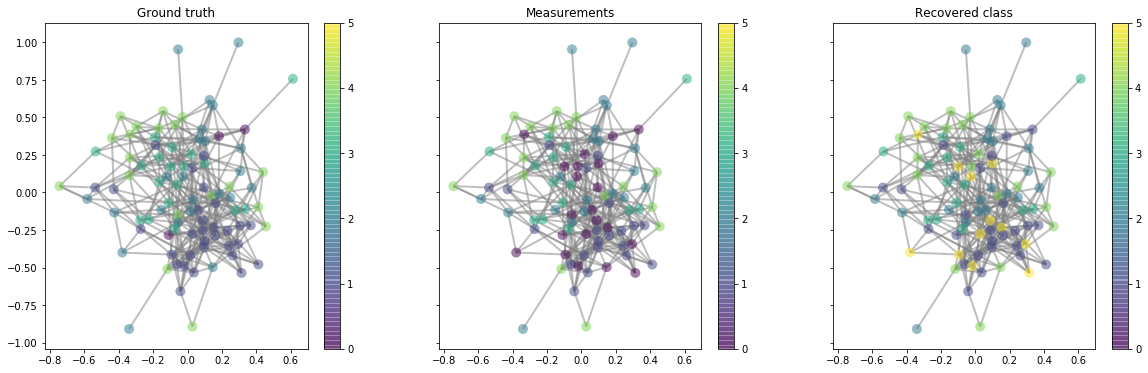

In [656]:
weighted_adjacency = epsilon_similarity_graph(genotype_df.values, metric='cosine', sigma=0.399, epsilon=0.1)
pygsp_weighted_graph = graphs.Graph(weighted_adjacency,lap_type='normalized') 
pygsp_weighted_graph.set_coordinates()
CV_discrete(pygsp_weighted_graph,top_discrete['X62'],genotype_df,0,100,True)


In [23]:
N_SIGMA = 1#20
N_EPS = 1#10
N_TAU = 1#5

In [24]:
def get_top_phen(n,dico):
    """
    return the n first top phenotypes with best score according to one of the dictionnary obtained by gridsearch/cv
    """
    maxo = lambda x: max(x,key = lambda x:x[1])
    maxvec = [(key,maxo(val)) for key,val in dico.items()]
    return sorted(maxvec,key = lambda x: x[1],reverse = True)[:n]

<font size="5">Genetic based</font>

In [25]:
#real parameters for genetic
METRICS = ['cosine','hamming','euclidean']

SIGMAS = {'cosine':np.linspace(0.3,0.6,N_SIGMA),\
          'hamming':np.linspace(0.18,0.29,N_SIGMA),\
          'euclidean':np.linspace(65,75,N_SIGMA)}

EPSILONS = {'cosine':np.linspace(0.06,0.14,N_EPS),\
            'hamming':np.arange(0.03,0.16,N_EPS),\
            'euclidean':np.linspace(0.15,0.32,N_EPS)}

TAUS = np.logspace(0,np.log10(10),N_TAU)

 <font size="3">Discrete features, genetic based</font>

In [326]:
# 2 hours
dic_disc_gen = grid_search_graphs(genotype_df,CV_discrete,METRICS,SIGMAS,EPSILONS,TAUS,top_disc,'dic_disc_gen')

0 / 3 combinations
1 / 3 combinations
2 / 3 combinations


In [327]:
with open('results/dic_disc_gen.pickle','rb') as f:
    dic_disc_gen = pickle.load(f)
get_top_phen(5,dic_disc_gen)

[('X111',
  [0.4702084701031307, 0.7386856776881007, 'hamming', 0.18, 0.03, 1.0]),
 ('X64', [0.29067452765718554, 0.3185593747311004, 'cosine', 0.3, 0.06, 1.0]),
 ('X62', [0.2766657765934517, 0.3023203711119649, 'cosine', 0.3, 0.06, 1.0]),
 ('X63',
  [0.2708903990855848, 0.44618158958718246, 'hamming', 0.18, 0.03, 1.0]),
 ('X152', [0.23743931342493443, 0.3720091841169106, 'cosine', 0.3, 0.06, 1.0])]

 <font size="3"> Continuous features, genetic based</font>

In [328]:
#3 hours
dic_cont_gen = grid_search_graphs(genotype_df,CV_continuous,METRICS,SIGMAS,EPSILONS,TAUS,top_cont,'dic_cont_gen')

0 / 3 combinations
1 / 3 combinations
2 / 3 combinations


In [330]:
with open('results/dic_cont_gen.pickle','rb') as f:
    dic_cont_gen = pickle.load(f)
get_top_phen(5,dic_cont_gen)

[('X332',
  [-0.01868666147484117, 2900.2592053791996, 'euclidean', 65.0, 0.15, 1.0]),
 ('X3820',
  [-0.019239978604254186, 0.4826610159240375, 'hamming', 0.18, 0.03, 1.0]),
 ('X4256',
  [-0.01976806462103966, 64.19024619143606, 'euclidean', 65.0, 0.15, 1.0]),
 ('X4849',
  [-0.033274172243531026, 60.237654689265575, 'euclidean', 65.0, 0.15, 1.0]),
 ('X3903',
  [-0.048064775118813116, 51.20755836113595, 'euclidean', 65.0, 0.15, 1.0])]

 <font size="5">Expression based

In [ ]:
#real params for expression
METRICS_E = ['euclidean','minkowski']

SIGMAS_E = {'euclidean':np.logspace(np.log10(42),np.log10(4000),N_SIGMA),\
            'minkowski':np.logspace(np.log10(50),np.log10(2000),N_SIGMA)}

EPSILONS_E = {'euclidean':np.linspace(0.1,0.6,N_EPS),\
              'minkowski':np.linspace(0.1,0.6,N_EPS)}

TAUS_E = np.logspace(0,np.log10(10),N_TAU)

 <font size="3"> Discrete features, expression based

In [ ]:
#2hours
dic_disc_exp = grid_search_graphs(expr_df,CV_discrete,METRICS_E,SIGMAS_E,EPSILONS_E,TAUS_E,top_disc,'dic_disc_exp')

In [ ]:
with open('results/dic_disc_exp.pickle','rb') as f:
    dic_disc_exp = pickle.load(f)
get_top_phen(5,dic_disc_exp)

 <font size="3">Continuous features, expression based

In [ ]:
#3 hours
dic_cont_exp = grid_search_graphs(genotype_df,CV_continuous,METRICS_E,SIGMAS_E,EPSILONS_E,TAUS_E,top_cont,'dic_cont_exp')

In [ ]:
with open('results/dic_cont_exp.pickle','rb') as f:
    dic_cont_exp = pickle.load(f)
get_top_phen(5,dic_cont_exp)

 <font size="5">PostAnalysis of the best genes

In [512]:
def cross_validation(X,y,predictor,metric1,metric2,N=50,discrete = True):
    """
    performs cross_validation on X,y given 2 metrics and a predictor (discrete and continuous)
    """
    met1,met2 = 0,0
    for i in range(N):
        X_train,X_test,y_train,y_test = train_test_split(X,y)
        predictor = predictor.fit(X_train,y_train)
        if discrete:
            y_hat = np.argmax(predictor.predict_proba(X_test),axis = 1)
        else:
            y_hat = predictor.predict(X_test)
        met1 += metric1(y_test,y_hat)
        met2 += metric2(y_test,y_hat)
    met1 /= N
    met2 /= N
    print('%s:%.2f \n%s:%.2f'% (str(metric1).split()[1],met1,str(metric2).split()[1],met2))

In [26]:
with open('results/dic_cont_gen_tikh.pickle','rb') as f:
    dic_cont_gen = pickle.load(f)
with open('results/dic_disc_gen_tikh.pickle','rb') as f:
    dic_disc_gen = pickle.load(f)
with open('results/dic_cont_exp_tikh.pickle','rb') as f:
    dic_cont_exp = pickle.load(f)
with open('results/dic_disc_exp_tikh.pickle','rb') as f:
    dic_disc_exp = pickle.load(f)

<div class="alert alert-block alert-info">
We now check which genes gave the best results with the grid search.
</div>

In [27]:
num_top = 8

In [28]:
for i in get_top_phen(num_top,dic_cont_exp):
    print(i)

('X424', [-0.400949856574394, 2.6503352887094382, 'euclidean', 53.38229267430309, 0.15555555555555556, 1.7782794100389228])
('X2334', [-1.3430490970166533, 49.59092924984011, 'minkowski', 60.7140146726929, 0.3222222222222222, 10.0])
('X1646', [-1.4441861276560215, 0.7109411931515579, 'minkowski', 73.72383155351937, 0.43333333333333335, 10.0])
('X5029', [-2.376681781175447, 213.43734074111737, 'minkowski', 60.7140146726929, 0.26666666666666666, 1.0])
('X1206', [-4.211053227488027, 5.508966380904229, 'euclidean', 53.38229267430309, 0.3222222222222222, 3.1622776601683795])
('X3820', [-4.632823471577259, 2.4524551074842353, 'euclidean', 53.38229267430309, 0.6, 1.7782794100389228])
('X4256', [-6.533557280143876, 449.03037177685843, 'euclidean', 53.38229267430309, 0.43333333333333335, 3.1622776601683795])
('X4849', [-8.724192669975888, 531.2322191457436, 'minkowski', 73.72383155351937, 0.5444444444444444, 3.1622776601683795])


In [29]:
for i in get_top_phen(num_top,dic_cont_gen):
    print(i)

('X424', [-0.5475545114260266, 2.85667396250802, 'cosine', 0.3157894736842105, 0.11333333333333334, 1.0])
('X2334', [-1.158007937204316, 48.39461210656759, 'cosine', 0.3157894736842105, 0.10444444444444445, 1.0])
('X1646', [-1.6008311989195811, 0.7430701571680468, 'cosine', 0.3, 0.11333333333333334, 1.0])
('X5029', [-1.7532867849603972, 219.20027209310237, 'cosine', 0.34736842105263155, 0.12222222222222223, 1.0])
('X1206', [-3.708295270969645, 5.193286025444978, 'cosine', 0.3, 0.14, 1.0])
('X3820', [-4.142798251274975, 2.202260771579255, 'cosine', 0.3, 0.14, 3.1622776601683795])
('X4256', [-5.721671459778367, 401.53378973636785, 'cosine', 0.3, 0.14, 1.0])
('X3903', [-7.57455383649496, 413.18520669566686, 'cosine', 0.3, 0.14, 10.0])


In [30]:
for i in get_top_phen(num_top,dic_disc_gen):
    print(i)

('X111', [0.6115071454936009, 0.8052309863154997, 'cosine', 0.3789473684210526, 0.08666666666666667, 1.0])
('X62', [0.38304916792445476, 0.5219729667522172, 'cosine', 0.3631578947368421, 0.07777777777777778, 1.0])
('X64', [0.36999221431531587, 0.5202219820381139, 'cosine', 0.3789473684210526, 0.09555555555555556, 3.1622776601683795])
('X63', [0.36032869004343326, 0.5172506770013162, 'euclidean', 71.84210526315789, 0.3011111111111111, 1.0])
('X152', [0.33922003780450505, 0.6879209151312935, 'cosine', 0.4263157894736842, 0.11333333333333334, 1.0])
('X61', [0.1788995154020054, 0.2335634920634921, 'cosine', 0.3631578947368421, 0.08666666666666667, 1.7782794100389228])
('X4473', [0.0, 0.9293959757768144, 'euclidean', 67.63157894736842, 0.20666666666666667, 10.0])
('X76', [0.0, 0.8509401850501394, 'cosine', 0.5368421052631579, 0.06888888888888889, 5.623413251903491])


In [31]:
for i in get_top_phen(num_top,dic_disc_exp):
    print(i)

('X111', [1.0, 1.0, 'euclidean', 42.00000000000001, 0.1, 1.0])
('X152', [0.8854394155067989, 0.9362472025738277, 'minkowski', 286.9726621462459, 0.15555555555555556, 3.1622776601683795])
('X546', [0.8429141665817353, 0.9311416631184432, 'euclidean', 587.3223641714421, 0.2111111111111111, 10.0])
('X1012', [0.7930090255718667, 0.9108565552094963, 'minkowski', 73.72383155351937, 0.5444444444444444, 1.7782794100389228])
('X64', [0.3089046168549888, 0.4906626687725759, 'minkowski', 1356.4134946975132, 0.4888888888888888, 3.1622776601683795])
('X62', [0.30356242022579655, 0.49377869258364626, 'euclidean', 139.31213518284594, 0.5444444444444444, 10.0])
('X63', [0.29814712721004877, 0.5059279458931162, 'minkowski', 2000.0000000000002, 0.5444444444444444, 5.623413251903491])
('X4473', [0.0, 0.9400482948424127, 'minkowski', 89.52139581335031, 0.5444444444444444, 1.0])


<div class="alert alert-block alert-info">
And reproduce the result in the following subsections.
</div>

<font size="3"> BXD epochs

Used mapping: 	 {1: -1.0, 2: 1.0}
MCC:1.00 
Accuracy:1.00


(1.0, 1.0)

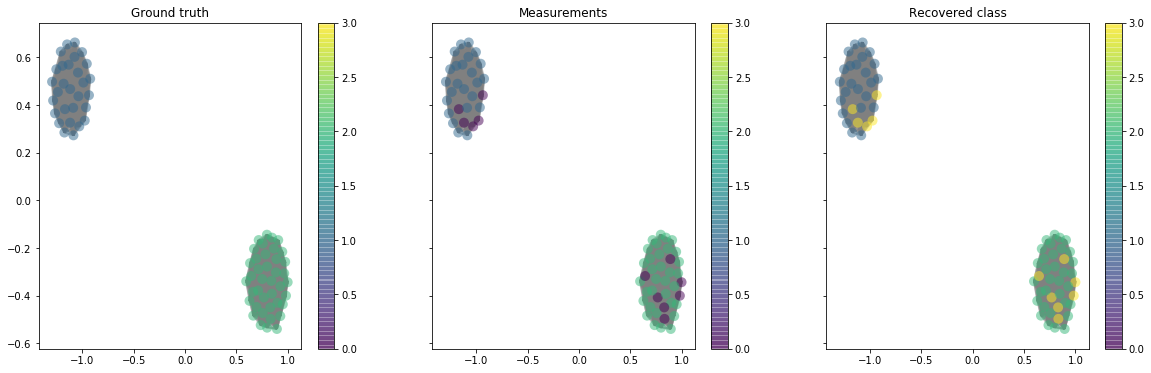

In [32]:
weighted_adjacency = epsilon_similarity_graph(expr_df.values, metric='euclidean', sigma=60, epsilon=0.2)
pygsp_weighted_graph = graphs.Graph(weighted_adjacency,lap_type='normalized')
pygsp_weighted_graph.set_coordinates()
CV_discrete(pygsp_weighted_graph,phenotype_df.loc['X111'],expr_df,1,NUM_REPET=15,plot = True)

MCC:0.23 
Accuracy:0.42


(0.23241108920882783, 0.42367174693261656)

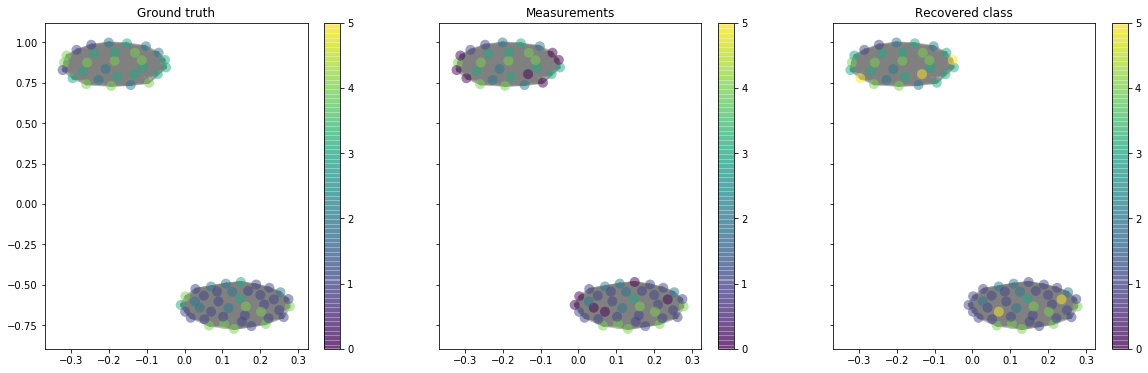

In [361]:
weighted_adjacency = epsilon_similarity_graph(expr_df.values, metric='minkowski', sigma=70, epsilon=0.2)
pygsp_weighted_graph = graphs.Graph(weighted_adjacency,lap_type='normalized')
pygsp_weighted_graph.set_coordinates()
CV_discrete(pygsp_weighted_graph,phenotype_df.loc['X62'],expr_df,1,NUM_REPET=15,plot = True)

<div class="alert alert-block alert-info">
We see that the features X111 X152 X546 X1012 obtained an unusually high accuracy compared to others. The first potential explanation would be the sex of the mouses
</div>

In [1]:
male = pd.read_csv('./data/expression_data/Adrenal_Male.txt', sep='\t', index_col=None, header=0)
male.drop(columns = ['gene'],inplace = True)
female = pd.read_csv('./data/expression_data/Adrenal_Male.txt', sep='\t', index_col=None, header=0)
female.drop(columns = ['gene'],inplace = True)

dic_m = dict(np.array([male.columns.values,[0]* male.columns.shape[0]]).T)
dic_f = dict(np.array([female.columns.values,[1]* female.columns.shape[0]]).T)
dico = {**dic_m, **dic_f}

NameError: name 'pd' is not defined

In [3]:
dic_m.keys() == dic_f.keys()

True

<div class="alert alert-block alert-info">
So the strains don't have any specific sex. Let's take a closer look at the concerned genes.
</div>

In [431]:
print(phenotype_id_aligner.loc['X111'].Phenotype)
print(phenotype_id_aligner.loc['X152'].Phenotype)
print(phenotype_id_aligner.loc['X546'].Phenotype)
print(phenotype_id_aligner.loc['X1012'].Phenotype)

Genetics, statistics, cofactors: BXD epoch or phase of production trait 2 [-1 = Taylor BXD series BXD1 to 42, 1 = UTHSC BXD series BXD43 and higher]
Genetics, statistics, cofactors: BXD epoch or phase of production trait 1 [-1 = Taylor BXD series BXD1 to 32, 0 = Taylor series BXD33 to 42, 1 = UTHSC BXD series BXD43 and higher]
Genetics, statistics, cofactors: BXD epoch or phase of production trait 3 [-1 = Taylor BXD series BXD1 to 32, 1 = Taylor series BXD33 to 42 and all UTHSC BXD series BXD43 and higher]
Genetics, statistics, cofactors: BXD epoch or phase of production trait 4 [-1 = Taylor BXD series BXD1 to 30, 0 = BXD31 and higher]


<div class="alert alert-block alert-info">
It looks that somehow, all these genes are related. We then show that it is not due to chance, as only one other gene is part of theses serie of Genetics,statistics and cofactors.
</div>

In [429]:
phenotype_id_aligner[phenotype_id_aligner.Phenotype.str.contains('BXD epoch')]

,PhenoID.1,RecordID,Phenotype,Shown_pheno,Category,Category_ID,color,Phenotype_post,Phenotype_pre,Authors,Senior.Author,Abbreviation,quantitative_trait,Tissues,Diet,Strains
PhenoID,,,,,,,,,,,,,,,,
X2164,2164,11018,"Central nervous system, morphology: Forebrain ...","Forebrain weight, adjusted by age, sex, body w...",Morphology,2616.0,9.0,"Central nervous system, morphology: Forebrain ...","Central nervous system, morphology: Forebrain ...","Kim Acklin, Lu Lu, Robert Williams",Williams,NaN,Yes,brain,NaN,83
X152,152,12688,"Genetics, statistics, cofactors: BXD epoch or ...",BXD epoch or phase of production trait 1 [-1 =...,Other,4742.0,12.0,"Genetics, statistics, cofactors: BXD epoch or ...","Genetics, statistics, cofactors: BXD epoch or ...",Williams RW,Williams,NaN,No,NaN,NaN,93
X111,111,12689,"Genetics, statistics, cofactors: BXD epoch or ...",BXD epoch or phase of production trait 2 [-1 =...,Other,4743.0,12.0,"Genetics, statistics, cofactors: BXD epoch or ...","Genetics, statistics, cofactors: BXD epoch or ...",Williams RW,Williams,NaN,No,NaN,NaN,93
X546,546,12690,"Genetics, statistics, cofactors: BXD epoch or ...",BXD epoch or phase of production trait 3 [-1 =...,Other,4744.0,12.0,"Genetics, statistics, cofactors: BXD epoch or ...","Genetics, statistics, cofactors: BXD epoch or ...","Williams RW, Lu L",Williams,NaN,No,NaN,NaN,93
X1012,1012,13033,"Genetics, statistics, cofactors: BXD epoch or ...",BXD epoch or phase of production trait 4 [-1 =...,Other,4745.0,12.0,"Genetics, statistics, cofactors: BXD epoch or ...","Genetics, statistics, cofactors: BXD epoch or ...","Williams RW, Lu L",Williams,NaN,No,NaN,NaN,92


<div class="alert alert-block alert-info">
A deeper look of the phenotype could be useful, the concerned person was thus contacted for more information.
</div>

In [169]:
X = expr_df.copy()
for c in X:
    X[c] = X[c].replace(np.nan,X[c].mean())
y = phenotype_df.loc['X111'][expr_df.index]
y.replace(-1,0,inplace = True)

In [174]:
cross_validation(X,y,LogisticRegression(),matthews_corrcoef,accuracy_score,100)

MCC:0.95 
Accuracy:0.98


<div class="alert alert-block alert-info">
Logistic regression performs as well as our classifier.
</div>

<font size="3"> Color

Used mapping: 	 {1: 1.0, 4: 4.0, 3: 3.0, 2: 2.0, 0: nan}
MCC:0.40 
Accuracy:0.55


(0.40029948134078225, 0.5467753872417543)

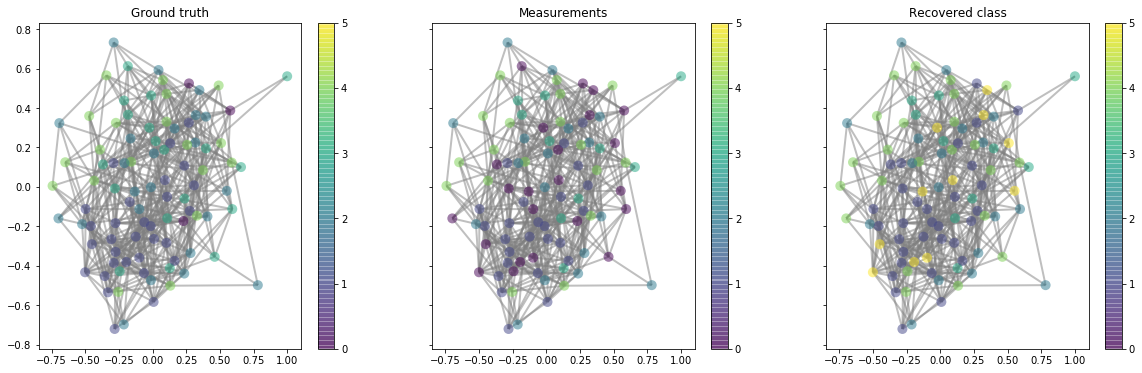

In [672]:
X = genotype_df.copy()
y = phenotype_df.loc['X62'][X.index].copy()
weighted_adjacency = epsilon_similarity_graph(genotype_df.values, metric='cosine', sigma=0.4, epsilon=0.09)
pygsp_weighted_graph = graphs.Graph(weighted_adjacency,lap_type='normalized')
pygsp_weighted_graph.set_coordinates()
CV_discrete(pygsp_weighted_graph,phenotype_df.loc['X62'],genotype_df,0,NUM_REPET=1000,plot = True)

<div class="alert alert-block alert-info">
Let's take a look at the corresponding phenotypes:
</div>

In [120]:
print(phenotype_id_aligner.loc['X62'].Phenotype)

Skin, pigmentation: Hair coat color, ordinal scale version 2 where black=4, grey=3, brown=2, dba dilute=1 [color intensity]


<div class="alert alert-block alert-info">
It seems like we already manage to separate decently the mouses according to their genes: however, we will try to outperform this model in the following sections.
</div>

In [669]:
X2 = genotype_df.copy()
y2 = phenotype_df.loc['X62'][genotype_df.index]
nanindx = y2[y2.isna()].index
X2.drop(nanindx,inplace = True)
y2.drop(nanindx,inplace = True)
y2 = y2-1
cross_validation(X,y,LogisticRegression(),matthews_corrcoef,accuracy_score,100)

MCC:0.47 
Accuracy:0.60


<div class="alert alert-block alert-info">
So we end up with an accuracy of 60% for thelogistic regression
</div>

## 4. Exploitation

#### 4.1 Feature imputation

##### 4.1.1 Baseline

In [19]:
expression_data_folder = data_folder + '/expression data/'

In [20]:
def open_expression_data(folder, txt_file):
    expression_data = pd.read_csv(folder + txt_file, delimiter ="\t", index_col='gene').transpose()
    expression_data.index.name = 'BXD_strain'
    
    return expression_data

In [21]:
expression_data_files = listdir(expression_data_folder)  
expression_data_files = [filename for filename in expression_data_files if filename.endswith(".txt")] # take only .txt files

In [22]:
df_expressions = [open_expression_data(expression_data_folder, f) for f in expression_data_files]
df_expression = pd.concat(df_expressions, ignore_index=False, sort=False, axis=1)
df_expression.drop(['B6D2F1', 'D2B6F1', 'C57BL.6J', 'DBA.2J'], axis=0, inplace=True)

In [25]:
# Remove duplicated columns + replace by mean
df_expression = df_expression.groupby(by=df_expression.columns, axis=1).mean()

In [26]:
# select features
# count nan by cols: select cols with less than 20 nans
features = df_expression[df_expression.columns[df_expression.isna().sum(axis=0) < 20]] #df_expression.isna().sum(axis=0)
features.shape

(93, 71085)

In [27]:
# For baseline: replace nans by mean
features = features.fillna(features.mean())

In [28]:
labels = df_phenotype.loc[strains][['X62']]

In [29]:
nan_strains = df_phenotype.loc[df_phenotype['X62'].isnull()==True].index.to_list()

In [30]:
features.drop(nan_strains, axis=0, inplace=True)
features.shape

(90, 71085)

In [31]:
labels.drop(nan_strains, axis=0, inplace=True)
labels.shape

(90, 1)

In [32]:
# RFE - recusrsive feature elimination

l_r = logistic = LogisticRegression(solver='lbfgs', max_iter=4000, multi_class='auto')
rfe = RFE(l_r, step = 0.1, verbose = True)
fit = rfe.fit(features.to_numpy(), labels.to_numpy().ravel())
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

Fitting estimator with 71085 features.
Fitting estimator with 63977 features.
Fitting estimator with 56869 features.
Fitting estimator with 49761 features.
Fitting estimator with 42653 features.
Fitting estimator with 35545 features.
Num Features: 35542
Selected Features: [ True False  True ... False  True False]
Feature Ranking: [1 6 1 ... 7 1 7]


In [33]:
selected_features = features.to_numpy()[:, rfe.support_]

In [34]:
logistic = LogisticRegression(solver='lbfgs', max_iter=4000, multi_class='auto')

accuracies = cross_val_score(logistic, selected_features, labels.to_numpy().ravel(), cv=5, scoring="accuracy")
print('Accuracy: {:.2f}'.format(np.mean(accuracies)))

Accuracy: 0.37


##### 4.1.2 Graph signal processing (GSP)

##### 4.1.3 Logistic regression following GSP

#### 4.1.4 Custom Graph Neural Network Approach

<div class="alert alert-info">
Load data --> genotype for adjacency matrix, expressions for features nodes and phenotype "X62" as label
</div>

In [ ]:
DATA_DIR = "../../Data/"

#Phenotype
pheno = pd.read_csv(DATA_DIR+'Phenotype.txt', sep="\t", index_col="PhenoID")
pheno.drop(['B6D2F1', 'D2B6F1', 'C57BL.6J', 'DBA.2J'], axis=1, inplace=True)
y = pheno.loc["X62"].dropna()
y_cat = pd.get_dummies(y)

#Genotype
geno = pd.read_csv(DATA_DIR+'Genotype_BXD.txt', sep="\t", index_col=["SNP"])
genotype_df = geno.loc[:,y.index].T

#Expression
filenames = glob.glob(DATA_DIR+"expression data" + "/*.txt")
dfs = [pd.read_csv(f, sep="\t") for f in filenames]
expression = pd.concat(dfs, ignore_index=True, sort=False)
expression = expression.set_index(["gene"])
expression.drop(['B6D2F1', 'D2B6F1', 'C57BL.6J', 'DBA.2J'], axis=1, inplace=True)
# keep only gene where there is less than 30 Nan // so more than 60 mice recorded.
nanByGene = expression.loc[:,y.index].isnull().sum(axis=1)
mask = nanByGene < 30
maskedEx = expression.loc[mask,y.index].T

<div class="alert alert-info">Generate Ajdacency from genotype</div>

In [ ]:
# Generate adjacency from genotype
weighted_adj = adjacency_subset(genotype_df, genotype_df.index, 'cosine')
weighted_adj = th.tensor(weighted_adj.todense())
g = graphs.Graph(weighted_adj,"normalized")

<div class="alert alert-info">Imputations methods</div>

In [ ]:
#Naive mean
maskedExMean = maskedEx.fillna(masedEx.mean(axis=0))

# Thikonov method
def tikhonov_imputation(G, meas):
    """Impute missing values to a ndarray signal of shape (G.N, # of features)"""
    assert isinstance(G, graphs.Graph)
    assert isinstance(meas, np.ndarray)
    #assert meas.shape[0] == G.n_vertices
    
    # Init
    meas_copy = np.copy(meas)    
    imputed_array = np.zeros(meas.shape)
    val_mask = ~np.isnan(meas_copy)

    for idx in range(meas.shape[1]):
        
        if (idx%10000 == 0):
            print(idx,"/",meas.shape[1])
        imputed_array[:, idx] = learning.regression_tikhonov(G, meas_copy[:, idx], val_mask[:, idx], tau=0.1)
    
    imputed_array[val_mask] = meas[val_mask]
    # Verify consistancy
    assert (meas[val_mask] == imputed_array[val_mask]).all()
    return imputed_array


maskedExTik = tikhonov_imputation(g, np.array(maskedEx))

<div class="alert alert-info">Features Selections / Generation of subsets</div>

In [ ]:
#RandomForest
clf = RandomForestClassifier(n_estimators=500, random_state=0, n_jobs=-1)
clf.fit(maskedExMean, y_cat)
top30RFind = np.argsort(clf.feature_importances_)[::-1][:30]
top30RF = maskedExMean[:,top30RFind]

#same with thikonov imputated values
clfTik = RandomForestClassifier(n_estimators=500, random_state=0, n_jobs=-1)
clfTik.fit(maskedExTik, y_cat)
top30RFind = np.argsort(clfTik.feature_importances_)[::-1][:30]
top30RFTik = maskedExTik[:,top30RFind]

In [ ]:
#Mutual Information
mi = mutual_info_classif(maskedExMean,y)
top30Ind = np.argsort(mi)[::-1][:30]
top30MI = maskedExMean[:,top30Ind]

#same with thikonov imputated values
miTik = mutual_info_classif(maskedExTik,y)
top30IndTik = np.argsort(mi)[::-1][:30]
top30MITik = maskedExTik[:,top30Ind]

In [ ]:
#Chi-squared
chi,_ = chi2(maskedExMedian,y_cat)
top30CHIind = np.argsort(chi)[::-1][:30]
top30CHI = maskedExMedian[:,top30CHIind]

#same with thikonov imputated values
chiTik,_ = chi2(maskedExMedian,y_cat)
top30CHIindTik = np.argsort(chi)[::-1][:30]
top30CHITik = maskedExMedian[:,top30CHIind]

<div class="alert alert-info">Startified Split of the data into train/test</div>

In [ ]:
labels = th.LongTensor(y_cat.values)
labels = np.argmax(labels,axis=1)

ind_0 = np.where(labels==0)[0][:12]
ind_1 = np.where(labels==1)[0][:12]
ind_2 = np.where(labels==2)[0][:12]
ind_3 = np.where(labels==3)[0][:12]

train_mask = [*ind_0,*ind_1,*ind_2,*ind_3]
valTest_mask = [i for i in range(len(labels)) if i not in train_mask]

ind_0 = np.where(labels==0)[0][12:12+9]
ind_1 = np.where(labels==1)[0][12:12+6]
ind_2 = np.where(labels==2)[0][12:12+3]
ind_3 = np.where(labels==3)[0][12:12+4]

val_mask = [*ind_0,*ind_1,*ind_2,*ind_3]
test_mask = [i for i in valTest_mask if i not in val_mask]

<div class="alert alert-info">Graph Neural Network construction</div>

In [ ]:
class GraphLayer(nn.Module):
    def __init__(self, in_features, out_features, activation=nn.LeakyReLU(0.6,True)):
        super(GraphLayer, self).__init__()
        fc = [nn.Linear(in_features, out_features)]
        if activation is not None:
            fc.append(activation)
        self.fc = nn.Sequential(*fc)
        
    def forward(self, A, x):
        """See randomWalk function to better understand as A was modified"""
        #Weighted average of neighbours's features.
        y = th.mm(A, x)
        
        return self.fc(y)

In [ ]:
class GNN(nn.Module):
    def __init__(self, num_feats, h1, h2, drop, num_classes):         
        super(GNN, self).__init__()
        self.gl1 = GraphLayer(num_feats,h1)
        self.gl2 = GraphLayer(h1,h2)
        self.fc3 = nn.Linear(h2, num_classes)
        self.Dropout = nn.Dropout(drop)

    def forward(self, A, x):
        x = self.Dropout(self.gl1(A,x))
        x = self.Dropout(self.gl2(A,x))
        return self.fc3(x) 

In [ ]:
def train(model, A, batchs, loss_fcn, train_mask, optimizer, n_neigh):
    model.train()  # Activate dropout
    
    losses_ = []
    real_batchs = 32
    for i in range(real_batchs):
        
        A_nn = randomWalk(A,2,n_neigh)
        
        for batch in batchs:

            features, labels = batch
            optimizer.zero_grad()
            logits = model(A_nn, features.float())
            loss = loss_fcn(logits[train_mask], labels[train_mask])
            loss.backward()
            optimizer.step()
            losses_.append(loss)
        
    return th.mean(th.stack(losses_))


def evaluate(model, A, features, labels, mask, n_neigh):
    model.eval()  # Deactivate dropout
    with th.no_grad():
        real_batchs = 32
        corrects = 0
        labels = labels[mask]
        mc_ = []
        for i in range(real_batchs):
            A_nn = randomWalk(A,2,n_neigh)
    
            logits = model(A_nn, features.float())[mask]  # only compute the evaluation set
            _, indices = th.max(logits, dim=1)
            corrects = corrects + th.sum(indices == labels)
            mc_.append(matthews_corrcoef(labels,indices))
            
        #return Accuracy and Mcc
        return corrects.item() * 1.0 / (len(labels)*real_batchs),  np.sum(mc_)/real_batchs

In [ ]:
def randomWalk(A, max_path=4, max_n=4):
    """Not actually a randomWalk but the idea is the same;
    Take only in account "max_n" randomly chosen neighbours of degree <= "max_path",
    weighted by the edge(s) in between.
    (degree == how many step from initial node to get to neighbour)"""
    
    A_1 = A.float() + th.eye(A.shape[0])
    A_n = F.normalize(A_1, p=1, dim=1)
    A_4 = np.linalg.matrix_power(A_n,max_path)
    
    for i in range(A.shape[1]):

        ind_non_empty = np.where(A_4[i,:] > 0)[0]
        
        if len(ind_non_empty) < max_n:
            select_ind = ind_non_empty
        else:
            select_ind = list(np.random.choice(ind_non_empty,max_n))

        select_ind = np.append(select_ind,i)
        A_4[i,~select_ind] = 0

    A_4t = th.tensor(A_4)
    A_nn = F.normalize(A_4t.float(), p=1, dim=1)
        
    return A_nn

<div class="alert alert-info">Graph Neural Network Training and Evaluation </div>

In [ ]:
#Generate result for 3 varying parameters; imputation method, Feature selection method, # of neighbours

subsets_ = [[top30RF, top30MI, top30CHI],[top30RFTik, top30MITik, top30CHITik]]
names = ["median","thikonov"]
subnames = ["RF","MI","CHI2"]
max_neighbours = [1,3,5,10]
max_trials = 10

WholeResults = {}

#imputing method
for mname, methodsubset in zip(names,subsets_):
    
    WholeResults[mname] = {}
    
    #Subsets derived from diff. Features Selection Methods
    for subname, subset in zip(subnames, methodsubset):
        
        WholeResults[mname][subname] = {}
        mm = MinMaxScaler()
        norm_subset = mm.fit_transform(subset)
        features, labels = th.tensor(norm_subset), th.LongTensor(y_cat.values)
        labels = np.argmax(labels,axis=1)

        model = GNN(num_feats,64, 32, 0.5, 4)
        loss_fcn = th.nn.CrossEntropyLoss()
        optimizer = th.optim.Adam(model.parameters(), lr=0.01)
        dataset = TensorDataset(features, labels)
        batchs = DataLoader(dataset,batch_size=90,shuffle=False,drop_last=False)

        #Test diff. # of neighbours
        for n in max_neighbours:
            print("new neigh:", n)
            neighname = "N" + str(n)
            WholeResults[mname][subname][neighname] = {}
            WholeResults[mname][subname][neighname]["train"] = {}
            WholeResults[mname][subname][neighname]["validation"] = {}
            WholeResults[mname][subname][neighname]["test"] = {}
            
            trials_results = np.zeros((max_trials,6))
            
            #Multiple Trials to get more robust results
            for t in range(max_trials):
                print("trial: ", t,"/",max_trials)
                
                results_ = np.zeros((15,4))
                for epoch in range(15):

                    loss = train(model, weighted_adj, batchs, loss_fcn, train_mask, optimizer, n)

                    val_acc, val_mcc = evaluate(model, weighted_adj, features, labels, val_mask, n)
                    tr_acc, tr_mcc = evaluate(model, weighted_adj, features, labels, train_mask, n)
                    results_[epoch,:] = [tr_acc, tr_mcc, val_acc, val_mcc]
                
                te_acc, te_mcc = evaluate(model, weighted_adj, features, labels, test_mask, n)
                trials_results[t,:] = [*results_.mean(axis=0),te_acc,te_mcc]
            
            
            #save all in dico WholeResults
            subdico_train = WholeResults[mname][subname][neighname]["train"]
            subdico_validation = WholeResults[mname][subname][neighname]["validation"]
            subdico_test = WholeResults[mname][subname][neighname]["test"]
            subdico_train["acc"],subdico_train["mcc"] = trials_results[:,:2].mean(axis=0) 
            subdico_validation["acc"],subdico_validation["mcc"] = trials_results[:,2:4].mean(axis=0) 
            subdico_test["acc"],subdico_test["mcc"] = trials_results[:,-2:].mean(axis=0)                    
                                       

#### 4.2 Phenotype prediction

##### 4.2.1 Harmonic function

In [35]:
# Using a phenotype present on most strain: X63 (3 nans only)
df_phenotype.loc[df_phenotype['X62'].isnull()==True].index.to_list()

['BXD37', 'BXD41', 'BXD54']

In [36]:
labels = df_phenotype.loc[strains][['X62']] 
labels = labels.to_numpy().ravel()

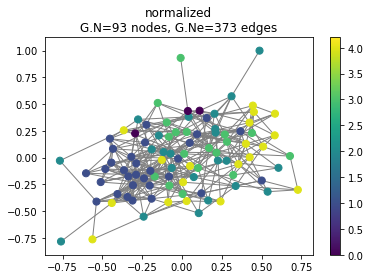

In [37]:
# Signal visualization
pygsp_graph = graphs.Graph(genotype_adjacency, 'normalized')
pygsp_graph.set_coordinates(kind='spring')
plotting.plot_signal(pygsp_graph, np.nan_to_num(labels, copy=True), backend=None, vertex_size=50)

In [38]:
nb_nodes = genotype_adjacency.shape[0]
train_mask, test_mask = hl.get_masks(nb_nodes, 0.1)

In [39]:
y_train = labels[train_mask]
y_test = labels[test_mask]

In [40]:
# Semi-supervised learning, assign training labels only
genotype_graph = nx.from_numpy_array(genotype_adjacency)

for node_number, node_value in zip(train_mask, y_train):
    genotype_graph.nodes[node_number]['label'] = node_value

In [41]:
# Classify remaining nodes
y_classification = node_classification.harmonic_function(genotype_graph)
y_hat = np.array(y_classification)[test_mask]

In [42]:
print('Accuracy: {:.2f}'.format(hl.compute_accuracy(y_test, y_hat)))
print('MCC: {:.2f}'.format(matthews_corrcoef(y_test, y_hat)))

Accuracy: 0.44
MCC: 0.21


##### 4.2.2 Logistic regression and RFE

<div class="alert alert-block alert-info">
We built so far a graph based all the genes on the genetic/expression similarities: the problem with such a method consists in adding too many non explanatory variables that adversely affect the results. A feature selection method was therefore used in order to assess which variable are truely useful in explaining a given phenotype.
</div>

In [381]:
def process_y(y):
    """
    preprocess y so that it matches the 
    """
    y_un = y.unique()
    y_un = y_un[~np.isnan(y_un)]
    m = dict(list(zip(np.sort(y_un),np.arange(y_un.shape[0]))))
    #in order to fit the argmax convention
    return y.replace(m)

In [441]:
def feat_selec(phen,phenotype_df,genotype_df,estimator,metric1,metric2,numb_feat = 10,discrete = True):
    """
    performs the feature selection using the estimator and assess the metrics passed in parameter on the best features.
    """
    selector = RFE(estimator, numb_feat, step=1000)#verbose = True)
    X = genotype_df.copy()
    y = phenotype_df.loc[phen][genotype_df.index].copy()
    if discrete:
        #we adapt y to the argmax convention
        y = process_y(y)
    
    nanindx = y[y.isna()].index
    X.drop(nanindx,inplace = True)
    y.drop(nanindx,inplace = True)
    
    selector = selector.fit(X,y)
    sup = selector.support_
    X_red = X[X.columns[sup]]
    
    cross_validation(X_red,y,estimator,metric1,metric2,50,discrete)
    return sup,X_red,y

<font size="3">Discrete Data

In [430]:
top_disc = phenotype_id_aligner.loc[top_disc].sort_values(by = 'Phenotype').index.values

In [459]:
top_disc = phenotype_id_aligner.loc[top_disc].sort_values(by = 'Phenotype',ascending = False).index.values
data_disc = {}
for phen in top_disc:
    print("%s: %s" % (phen,phenotype_id_aligner.loc[phen].Phenotype))
    estimator = LogisticRegression()
    data_disc[phen] = feat_selec(phen,phenotype_df,genotype_df,estimator,matthews_corrcoef,accuracy_score,20)
    print("\n")


X63: Skin, pigmentation: Hair coat color, ordinal scale version 3 where grey=1, black=2, brown=3, dba dilute=4 [color intensity]
matthews_corrcoef:0.52 
accuracy_score:0.64


X62: Skin, pigmentation: Hair coat color, ordinal scale version 2 where black=4, grey=3, brown=2, dba dilute=1 [color intensity]
matthews_corrcoef:0.98 
accuracy_score:0.99


X64: Skin, pigmentation: Hair coat color, ordinal scale version 1 black=4, brown=3, grey=2, dba dilute=1 [color intensity]
matthews_corrcoef:0.98 
accuracy_score:0.99


X4473: Metabolism, genetics: Mitochondrial strain origin (-1 = C57BL/6J and 1 = DBA/2J) [genotype]
matthews_corrcoef:0.71 
accuracy_score:0.97


X61: Hematology: Transthyretin protein serum band (prealbumin, Pre locus) detected by acylamide electrophoresis in adult males [a-genotype of DBA/2J with band is coded as 1, o-genotype without band is coded as -1]
matthews_corrcoef:0.96 
accuracy_score:1.00


X1012: Genetics, statistics, cofactors: BXD epoch or phase of production tra

<div class="alert alert-block alert-info">
We see that both the accuracy and mcc score are significantly better using this method. Let's don't stop here an take a look at the relevant SNPs for hair color: it turns out that only 10 features are enough for the hair color:

From these datas, we decide to investigate further the following phenotypes:
* X62 (hair color)
* X61 (Transthyretin protein serum band (prealbumin, Pre locus))
* X4473 (Metabolism, genetics: Mitochondrial strain origin (-1 = C57BL/6J and 1 = DBA/2J) [genotype])
</div>

<font size="3">X62: Hair color

In [629]:
sup,X,y = feat_selec('X62',phenotype_df,genotype_df,LogisticRegression(),matthews_corrcoef,accuracy_score,10)
estimator = LogisticRegression()
pred.fit(X,y)
w = pred.coef_
# we take a look at the 2 SNPs which do receive the highest coefficient in terms of absolute value
imp_gene_indxes  = [np.argsort(np.abs(col))[::-1][:2] for col in w]
print("Most relevant columns indexes:",imp_gene_indxes)

matthews_corrcoef:0.99 
accuracy_score:0.99
Most relevant columns indexes: [array([9, 3]), array([9, 8]), array([9, 8]), array([9, 8])]


In [630]:
print('9th gene (1st most important):',X.columns[9])
print('8th gene (2nd most important):',X.columns[8])

9th gene (1st most important): rs30336558
8th gene (2nd most important): rs32862298


<div class="alert alert-block alert-info">
It looks like the genes i and rs32862298 are the "most important" ones, we can now search where these SNP are situated on the genetic background by searching on http://genenetwork.org/: (NB: options type= genotype, dataset = BXD genotypes)
</div>

rs30336558 $\Rightarrow$ Chr9: 74.557367

rs32862298 $\Rightarrow$ Chr4: 81.455696

<div class="alert alert-block alert-info">
By now searching which genes are responsible for hair color in this strain, we find that Tyrp1 (chromosome 4) and Myo5a (chromosome 9) are the concerned genes.(https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3185026/) Remains the question: are these SNP situated on the same locuses as theses chromosomes? By making a second search on http://genenetwork.org/ we find the following
</div>

Myo5a $\Rightarrow$ Location: Chr9 75.223099 : Max LRS Chr 9 Location 74.557367 (for the vast majority of the entries)

Tyrp1 $\Rightarrow$ Location: Chr4: 81.188219 : Max LRS Location: Various Chromosomes

<div class="alert alert-block alert-info">
Interestingly, most of the data about the BXD strain for the Myo5a comes from... the EPFL/LISP laboratory! This results makes sense, as it is where our dataset came from.
Let's check how the method perform with these 2 genes only:
</div>


In [631]:
cross_validation(X[['rs30336558','rs32862298']],y,LogisticRegression(),matthews_corrcoef,accuracy_score)

matthews_corrcoef:0.99 
accuracy_score:0.99


Used mapping: 	 {1: 0.0, 4: 3.0, 3: 2.0, 2: 1.0}
MCC:0.98 
Accuracy:0.99


(0.9847852023015453, 0.9886991940773366)

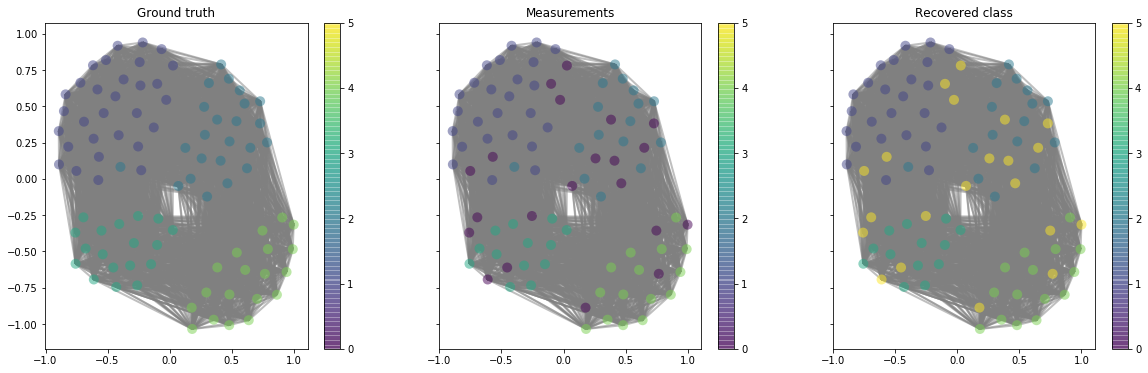

In [653]:
weighted_adjacency = epsilon_similarity_graph(X[['rs30336558','rs32862298']].values, metric='cosine', sigma=0.31, epsilon=0.004)
pygsp_weighted_graph = graphs.Graph(weighted_adjacency,lap_type='normalized') 
pygsp_weighted_graph.set_coordinates()
CV_discrete(pygsp_weighted_graph,y,X[['rs30336558','rs32862298']],0,NUM_REPET=1000,plot = True)

In [639]:
plt.savefig('./results/2phen_color')

<Figure size 432x288 with 0 Axes>

<font size="3">X61: Transthyretin protein serum band (prealbumin, Pre locus)

In [622]:
sup,X,y = feat_selec('X61',phenotype_df,genotype_df,estimator,matthews_corrcoef,accuracy_score,10)
pred = LogisticRegression()
pred.fit(X,y)
w = pred.coef_
# we take a look at the 2 SNPs which do receive the highest coefficient in terms of absolute value
imp_gene_indxes  = [np.argsort(np.abs(col))[::-1][:2] for col in w]
print("Most relevant columns indexes:",imp_gene_indxes)

matthews_corrcoef:0.98 
accuracy_score:1.00
Most relevant columns indexes: [array([6, 5])]


In [623]:
print('6th gene (1st most important):',X.columns[6])
print('5th gene (2nd most important):',X.columns[5])

6th gene (1st most important): rs8271271
5th gene (2nd most important): rs29190933


rs8271271 $\Rightarrow$ Chr12: 104.154182

rs29190933 $\Rightarrow$ Chr12: 103.283977

http://gn1.genenetwork.org/webqtl/main.py?FormID=geneWiki&symbol=Ttr 

Chr 12 from 104.2 to 105 Mb 

Used mapping: 	 {1: 0.0, 2: 1.0}
MCC:0.90 
Accuracy:1.00


(0.9, 1.0)

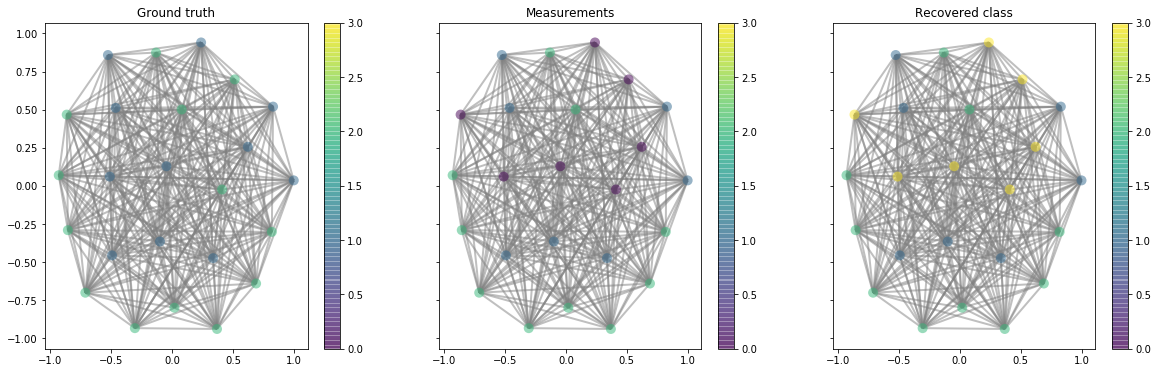

In [626]:
weighted_adjacency = epsilon_similarity_graph(X.values, metric='cosine', sigma=0.9, epsilon=0.004)
pygsp_weighted_graph = graphs.Graph(weighted_adjacency,lap_type='normalized') 
pygsp_weighted_graph.set_coordinates()
CV_discrete(pygsp_weighted_graph,y,X,0,plot = True)

<font size="3">Continuous Data

In [449]:
from sklearn.svm import SVR

In [458]:
top_cont = phenotype_id_aligner.loc[top_cont].sort_values(by = 'Phenotype',ascending = False).index.values
data_cont = {}
for phen in top_cont:
    print("%s: %s" % (phen,phenotype_id_aligner.loc[phen].Phenotype))
    estimator = SVR(kernel="linear")
    data_cont[phen] = feat_selec(phen,phenotype_df,genotype_df,estimator,r2_score,mean_squared_error,numb_feat = 100,discrete = False)
    print("\n")


X2397: Reproduction: Breeding performance, litter size within 24 hrs of birth at UTHSC (2000 to 2010)
r2_score:0.13 
mean_squared_error:0.63


X3820: Reproduction: Breeding performance at the Jackson Laboratory between 2008 and 2014 scored as a qualitative trait, where a score of 1 indicates that a strain may require special maintenance, exhibit reduced productivity, and/or experience some incidence of
r2_score:0.42 
mean_squared_error:0.27


X1302: Morphology: Body weight, statistically adjusted for variation in sex and age, and corrected for pregnancy (Hager et al., 2012) [g]
r2_score:0.54 
mean_squared_error:3.06


X699: Morphology: Body weight (no statistical adjustment) [g]
r2_score:-0.47 
mean_squared_error:12.73


X4482: Metadata, cofactor: Age at death (average) of hippocampal samples (use only with UTHSC BXD Aged Hippocampus Affy expression data sets) [days]
r2_score:0.69 
mean_squared_error:3238.79


X2041: Eye, visual system, physiology: Intraocular pressure (IOP), all ages 

<div class="alert alert-block alert-info">
From these datas, we decide to investigate further the following phenotypes:
    
* X2041: Eye, visual system, physiology: Intraocular pressure (IOP), all ages (1 to 30 months old), both sexes, average of left and right eyes
</div>

<font size="3">X2041: Eye, visual system, physiology: Intraocular pressure (IOP), all ages (1 to 30 months old), both sexes, average of left and right eyes

In [513]:
estimator = SVR(kernel='linear')
sup,X,y = feat_selec('X2041',phenotype_df,genotype_df,estimator,r2_score,mean_squared_error,numb_feat = 100,discrete = False)


r2_score:0.64 
mean_squared_error:0.96


50.70 % of the original data is kept


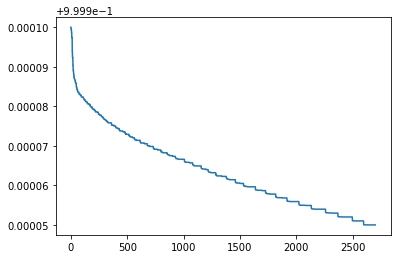

In [507]:
weighted_adjacency = epsilon_similarity_graph(X.values, metric='cosine', sigma=99, epsilon=0.99995)
plot_distrib(weighted_adjacency)

In [508]:
pygsp_weighted_graph = graphs.Graph(weighted_adjacency,lap_type='normalized') 
pygsp_weighted_graph.set_coordinates()
CV_continuous(pygsp_weighted_graph,phenotype_df.loc['X2041'],X,0)

(-0.09061919925415722, 2.6813859785514764)